# Assignment Day 9

## Team members:
- Samuel Nebgen s6sanebg@uni-bonn.de
- Muhammad Humza Arain s27marai@uni-bonn.de
- Julian Meigen s82jmeig@uni-bonn.de

## 18.09.2025

Contributions were made by all team members in around the same amount, either based on discussions or coding.

# Task 1: Load the Mutagenicity dataset from TUDatasets (https://chrsmrrs.github.io/datasets/docs/datasets/)


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
from torch_geometric.datasets import TUDataset

c:\Users\samue\Documents\Life Science Informatics\Semester 2\Machine Learning hands on\ML-handson\.venv\Lib\site-packages\torch_geometric\typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: Could not find module 'C:\Users\samue\Documents\Life Science Informatics\Semester 2\Machine Learning hands on\ML-handson\.venv\Lib\site-packages\libpyg.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
c:\Users\samue\Documents\Life Science Informatics\Semester 2\Machine Learning hands on\ML-handson\.venv\Lib\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: Could not find module 'C:\Users\samue\Documents\Life Science Informatics\Semester 2\Machine Learning hands on\ML-handson\.venv\Lib\site-packages\torch_cluster\_fps_cpu.pyd' (or one of its dependencies). Try 

In [3]:
save_data_path = os.path.join("..", "data", "interim")
dataset = TUDataset(root=save_data_path, name="Mutagenicity")

In [26]:
len(list(dataset))
for i in range(0, 11):
    print(f'Graph {i} has {dataset[i].num_nodes} nodes and {dataset[i].num_edges} edges.')


Graph 0 has 16 nodes and 32 edges.
Graph 1 has 72 nodes and 154 edges.
Graph 2 has 14 nodes and 26 edges.
Graph 3 has 36 nodes and 76 edges.
Graph 4 has 41 nodes and 86 edges.
Graph 5 has 11 nodes and 22 edges.
Graph 6 has 35 nodes and 72 edges.
Graph 7 has 8 nodes and 14 edges.
Graph 8 has 46 nodes and 90 edges.
Graph 9 has 50 nodes and 108 edges.
Graph 10 has 28 nodes and 58 edges.


In [23]:
dataset.x.shape

torch.Size([131488, 14])

In [45]:
count_non_mutagen= 0
count_mutagen = 0

for i in range (len(list(dataset))):
    
    if int(dataset[i].y[0]) == 1:
        count_non_mutagen += 1
    else:
        count_mutagen += 1

print(f'The dataset contains {count_non_mutagen} non-mutagen and {count_mutagen} mutagen molecules.')


The dataset contains 1936 non-mutagen and 2401 mutagen molecules.


# Task 2: Visualize the data by drawing the molecule graph of one sample.


### Using the predefined Code

In [5]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.utils import to_networkx


def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')
    
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}    
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    plt.show()


def to_molecule(data):
    ATOM_MAP = ['C', 'O', 'Cl', 'H', 'N', 'F',
                'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
    g = to_networkx(data, node_attrs=['x'])
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']
    return g

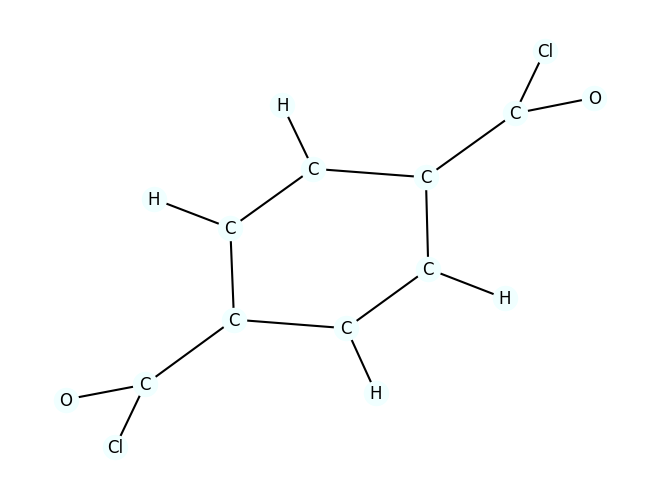

In [13]:
G = to_molecule(dataset[0])
draw_molecule(G)

### Only using Netwokx

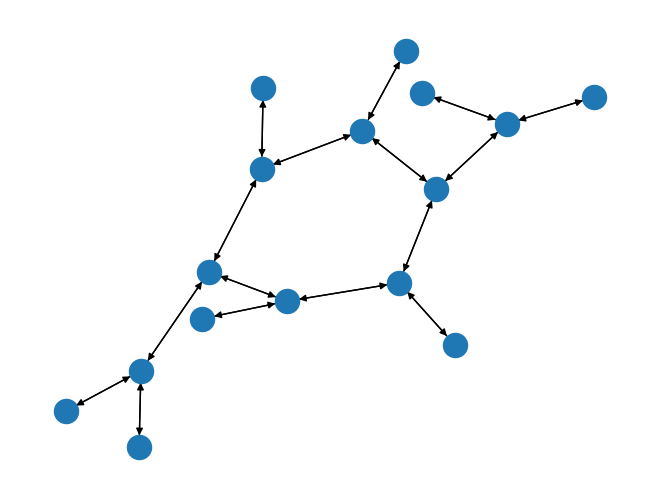

In [7]:
nx.draw(G)

# Task 3: Train a GNN model with 5 convolutional layers with pytorch-geometric.


## a. Define the model.


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn

from torch_geometric.nn import (
    GINEConv,            # supports edge_attr via edge_dim
    global_mean_pool,
    BatchNorm
)
from torch_geometric.loader import DataLoader  # <-- PyG DataLoader


class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, edge_dim, dropout=0.5):
        super(GCN, self).__init__()
        self.dropout = dropout

        # small helper to build the MLP used inside GINEConv
        def mlp(in_dim, out_dim):
            return nn.Sequential(
                nn.Linear(in_dim, out_dim),
                nn.ReLU(),
                nn.Linear(out_dim, out_dim),
            )

        # Convs that respect edge_attr (multi-d) via edge_dim
        self.conv1 = GINEConv(mlp(in_channels, hidden_channels), edge_dim=edge_dim)
        self.bn1   = BatchNorm(hidden_channels)

        self.conv2 = GINEConv(mlp(hidden_channels, hidden_channels), edge_dim=edge_dim)
        self.bn2   = BatchNorm(hidden_channels)

        self.conv3 = GINEConv(mlp(hidden_channels, hidden_channels), edge_dim=edge_dim)
        self.bn3   = BatchNorm(hidden_channels)

        self.conv4 = GINEConv(mlp(hidden_channels, hidden_channels), edge_dim=edge_dim)
        self.bn4   = BatchNorm(hidden_channels)

        self.conv5 = GINEConv(mlp(hidden_channels, hidden_channels), edge_dim=edge_dim)
        self.bn5   = BatchNorm(hidden_channels)

        # Readout head (richer than direct pooling to logits)
        self.head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(hidden_channels, out_channels),
        )

    def forward(self, graph):
        x, edge_index, edge_attr, batch = graph.x, graph.edge_index, graph.edge_attr, graph.batch

        x = self.conv1(x, edge_index, edge_attr); x = self.bn1(x); x = F.relu(x); x = F.dropout(x, p=self.dropout, training=self.training)
        h = x #sdaving the h for residual skip connections
        x = self.conv2(x, edge_index, edge_attr); x = self.bn2(x); x = F.relu(x)
        x = (x + h) / 2; x = F.dropout(x, p=self.dropout, training=self.training)
        h = x
        x = self.conv3(x, edge_index, edge_attr); x = self.bn3(x); x = F.relu(x)
        x = (x + h) / 2; x = F.dropout(x, p=self.dropout, training=self.training)
        h = x
        x = self.conv4(x, edge_index, edge_attr); x = self.bn4(x); x = F.relu(x)
        x = (x + h) / 2; x = F.dropout(x, p=self.dropout, training=self.training)
        h = x
        x = self.conv5(x, edge_index, edge_attr); x = self.bn5(x); x = F.relu(x)
        x = (x + h) / 2

        # graph-level pooling + head
        x = global_mean_pool(x, batch)
        x = self.head(x)  # logits [num_graphs, num_classes]
        return x

    

## b. Define the train and test function.


In [48]:
# first split the data using a stratified split
from torch_geometric.loader import DataLoader  # fixed
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import numpy as np

y = np.array([int(data.y) for data in dataset])
idx = np.arange(len(dataset))

train_idx, test_idx = train_test_split(
    idx, test_size=0.2, random_state=42, stratify=y
)

train_dataset = Subset(dataset, train_idx.tolist())
test_dataset  = Subset(dataset, test_idx.tolist())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False)


In [ ]:
# defining the training function

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss, total, correct = 0.0, 0, 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = F.cross_entropy(out, batch.y)
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * batch.y.size(0)
        pred = out.argmax(dim=1)
        correct += int((pred == batch.y).sum())
        total += batch.y.size(0)
    return total_loss / total, correct / total

In [50]:
#defining the test/evaluate function

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total_loss, total, correct = 0.0, 0, 0
    for batch in loader:
        batch = batch.to(device)
        out = model(batch)
        loss = F.cross_entropy(out, batch.y)
        total_loss += float(loss) * batch.y.size(0)
        pred = out.argmax(dim=1)
        correct += int((pred == batch.y).sum())
        total += batch.y.size(0)
    return total_loss / total, correct / total

## c. Train the model for 100 epochs.


In [49]:
def fit(model, train_loader, test_loader, epochs=100, lr=1e-3, weight_decay=5e-4, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(1, epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, device)
        te_loss, te_acc = evaluate(model, test_loader, device)
        print(f"Epoch {epoch:03d} | train_loss {tr_loss:.4f} acc {tr_acc:.4f} | "
              f"test_loss {te_loss:.4f} acc {te_acc:.4f}")

edge_dim = dataset[0].edge_attr.size(-1)
num_classes = 2
model = GCN(in_channels=dataset.num_node_features,
            hidden_channels=128,
            out_channels=num_classes,
            edge_dim=edge_dim,
            dropout=0.5)

fit(model, train_loader, test_loader, epochs=100, lr=1e-3, weight_decay=5e-4)


C:\Users\samue\AppData\Local\Temp\ipykernel_21012\359362569.py:12: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  total_loss += float(loss) * batch.y.size(0)


Epoch 001 | train_loss 0.6268 acc 0.6460 | test_loss 0.6095 acc 0.6221
Epoch 002 | train_loss 0.5773 acc 0.6904 | test_loss 0.6055 acc 0.6624
Epoch 003 | train_loss 0.5550 acc 0.7140 | test_loss 0.5420 acc 0.7166
Epoch 004 | train_loss 0.5457 acc 0.7334 | test_loss 0.6082 acc 0.6935
Epoch 005 | train_loss 0.5450 acc 0.7290 | test_loss 0.5263 acc 0.7500
Epoch 006 | train_loss 0.5394 acc 0.7336 | test_loss 0.5270 acc 0.7408
Epoch 007 | train_loss 0.5300 acc 0.7345 | test_loss 0.5359 acc 0.7465
Epoch 008 | train_loss 0.5263 acc 0.7394 | test_loss 0.5011 acc 0.7719
Epoch 009 | train_loss 0.5292 acc 0.7481 | test_loss 0.5398 acc 0.7488
Epoch 010 | train_loss 0.5155 acc 0.7564 | test_loss 0.4919 acc 0.7788
Epoch 011 | train_loss 0.5124 acc 0.7579 | test_loss 0.5037 acc 0.7604
Epoch 012 | train_loss 0.5080 acc 0.7593 | test_loss 0.4823 acc 0.7880
Epoch 013 | train_loss 0.5036 acc 0.7610 | test_loss 0.5025 acc 0.7707
Epoch 014 | train_loss 0.5056 acc 0.7688 | test_loss 0.4956 acc 0.7765
Epoch 

# Task 4: Explain the predictions using the captum package (https://captum.ai/) with the method Integrated Gradients.


## a. Familiarize yourself with the method, and the captum package (https://captum.ai/docs/extension/integrated_gradients). Summarize the method in your own words (5-8sentences).


Captums Integrated Gradients is a technique used to interpret the importance that individual input features have on a model's predictions. The technique works by comparing a models output for a given, randomly chosen input to a so called baseline input, which is typically a zeroed out version of the original input (e.g. a black image for image data, uninformative Graph with no Edges). The method computes the gradients of the model's output with respect to the input features, and integrates these gradients along a path from the baseline to the actual input. This means, that at every step along the path, the gradient is calculated and summed up to get a total importance score for each feature. At the end, the result is an attribution score for each input feature, showing how much that feature contributed to the difference between the model’s output at the baseline and the model’s output at the real input.

https://arxiv.org/pdf/1703.01365


## b. Calculate the attributions of the input to the model’s predictions.


In [54]:
import captum
from captum.attr import Saliency, IntegratedGradients


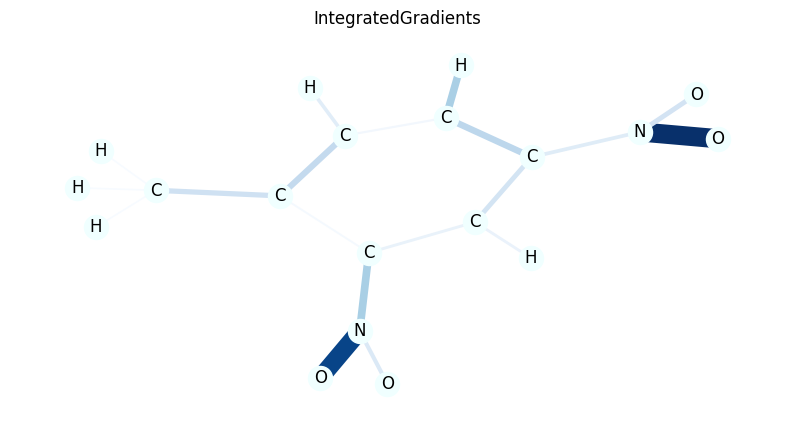

In [ ]:
from torch_geometric.data import Data
from captum.attr import Saliency, IntegratedGradients
import numpy as np

# --- helper: add batch info if missing (needed by global_mean_pool) ---
def ensure_batch_on_data(data):
    if not hasattr(data, "batch") or data.batch is None:
        data.batch = torch.zeros(data.num_nodes, dtype=torch.long)
    return data

def model_forward(edge_mask, data):
    data = ensure_batch_on_data(data)

    # scale edge_attr by mask
    edge_attr = data.edge_attr
    edge_mask = edge_mask.view(-1, 1)           # shape [E,1] for broadcasting
    masked_edge_attr = edge_attr * edge_mask

    # build new data object with masked edges
    graph = Data(
        x=data.x,
        edge_index=data.edge_index,
        edge_attr=masked_edge_attr,
        batch=data.batch,
    )

    logits = model(graph)   # [num_graphs, num_classes]
    return logits

def explain(data, target=0):
    data = ensure_batch_on_data(data)

    E = data.edge_index.size(1)
    input_mask = torch.ones(E, requires_grad=True)

    model.eval()

    
    ig = IntegratedGradients(model_forward)
    mask = ig.attribute(
            input_mask,
            target=target,
            additional_forward_args=(data,),
            internal_batch_size=min(256, E)
        )
    

    edge_mask = np.abs(mask.detach().numpy())
    if edge_mask.max() > 0:
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask


data = random.choice([t for t in test_dataset if not t.y.item()])
mol = to_molecule(data)

edge_mask = explain( data, target=0)
edge_mask_dict = aggregate_edge_directions(edge_mask, data)
plt.figure(figsize=(10, 5))
plt.title('IntegratedGradients')
draw_molecule(mol, edge_mask_dict)

## c. Visualize your results. Which were the most important inputs for a prediction?


See above for the visualization. The most important inputs for the prediction are the thickest and darkest edges in the Graph. In this example, the most important edges are the ones between N and O, because NO2 is a known mutagenic group.

# Task 5: Use the GNNExplainer from pytorch-geometric to explain the model’s predictions.


## a. Familiarize yourself with the method (https://arxiv.org/pdf/1903.03894 ). Summarize the method in your own words (5-8 sentences).


The GNNExplainer is an explainability tool that tries to create a subgraph and a subset of node features that are the most important for a GNNs prediction. In practice, GNNExplainer tries to find a subgraph that maximizes the mutual information between the prediction of the GNN on the full grpah and the prediction of the GNN on the subgraph. It learns a mask over the edges and the node features. Every Node and Edge gets a score between 0 and 1, that describes how much it will be considered in the prediction. The goal is, to find a mask that minimizes the size of the subgraph, while still keeping the same prediction as the full graph. Gradient descent is used to optimize the mask. The final result is a subgraph and a subset of node features that are the most important for the GNNs prediction.

## b. Visualize your results. Choose an interesting prediction and show the most important input.